# Synthetic Data Exploration

In this file, I will be implementing different ecological spread models to generate synthetic geospatial population data for invasive species modeling. Per our conversation on 3/6/24, Professor Brantingham recommended that we implement the **Lotka-Volterra Model** and the **Tilman model** to understand competition between two species. I will be implementing these as a starting point.

## Lotka-Voltera Model

This model explores how competition influences the abundance of two competing species in a region where the specific competitive mechanism does not need to be known. This model originated in modeling predator-prey dynamics, which translates very well to our invasive species context where invasive species are the predators.

To implement this model, we will be using the following tutorial to get started: https://softinery.com/blog/lotka-volterra-model-and-simulation/, that breaks down the implemntation into x parts:
- imports
- defining the optimization equations
- initializing the environment
- solving the environment over time
- plotting the results

Note that this tutorial works on a specific region and the number of predator and prey species at a given timestep. For our purposes, we want a geospatial map of related points where these numbers are calculated to create a heat-map of predator locations. I found this paper that explicitly discusses L-V heatmaps in section 4.4.3: https://ppgfis.ufba.br/sites/ppgfis.ufba.br/files/rafael_menezes_msc_dissertationupdated.pdf. The general theoretic idea is to use a specified aggregation function to gather the numbers of predators at a certain timestep for a given unit area of a region and to shade that region accordingly. As the original repo from the paper is dead, I found some potential github leads:
- https://github.com/r-menezes/SpatialPreyPred/tree/main: seems to generate vector fields of species
- https://github.com/SteevenJanny/DeepKKL/blob/master/data_generation/datagen_LotkaVolterra.py: seems to generate LV data, not sure about expansion to heatmaps

In [13]:
# data generation. Based on work from https://github.com/SteevenJanny/DeepKKL/blob/master/data_generation/datagen_LotkaVolterra.py

# imports
from scipy.integrate import solve_ivp
import numpy as np
from tqdm import tqdm

#Constants: Simulation Parameters
ALPHA = 2 / 3
BETA = 4 / 3
GAMMA = 1
DELTA = 1

# lotka-volterra model dynamics. Defines the partials in terms of the simulation constants
def dynamics(t, y):
    """Lotka Volterra model"""
    out = np.zeros_like(y)
    out[0] = y[0] * (ALPHA - BETA * y[1])
    out[1] = y[1] * (DELTA * y[0] - GAMMA)
    return out


'''generate(): creates np file simulating multiple trajectories of Lotka Volterra's system. The args are:
    num_traj: number of trajectories to simulate. default 200
    len_traj: length of a trajectory (in seconds). default 25
    pts_per_sec: number of points per second. default 40
    save_loc: where to save created files
'''
def generate(num_traj=200,len_traj=25, pts_per_sec=100,save_loc='../Dataset/val.npy',prey_range=(1, 5), predator_range=(1, 3)):
    dataset = np.zeros((num_traj, 2, len_traj * pts_per_sec))  # That will store each simulation
    t_span = [0, len_traj]
    t_eval = np.linspace(0, len_traj, len_traj * pts_per_sec)  # Time vector

    # Change this line to configure how much you downsample the data, and the final time range
    downsample_rate = int(len(t_eval) / (len_traj * pts_per_sec))
    idx = np.arange(0, len(t_eval), downsample_rate)


    for k in tqdm(range(num_traj)):
        # Generate random initial values for prey and predator populations within the specified ranges
        y0 = np.random.uniform(prey_range[0], prey_range[1], size=2)
        y0[1] = np.random.uniform(predator_range[0], predator_range[1])

        y0 = np.random.random(2) * 2
        sol = solve_ivp(dynamics, y0=y0, t_span=t_span, t_eval=t_eval)
        dataset[k] = sol.y[:, idx]

    np.save(save_loc, dataset)

generate()

100%|██████████| 200/200 [00:00<00:00, 334.08it/s]


In [ ]:
# generation of data heatmaps

#imports
import numpy as np
import matplotlib.pyplot as plt

# Load the .npy file containing the simulation data
data = np.load('../Dataset/val.npy')

# Extract predator population data (second variable in the array)
predator_data = data[:, 1, :]

# Calculate average predator population at each time step across all trajectories
average_predator_population = np.mean(predator_data, axis=0)

# Reshape the data into a 2D grid representing predator population over time
grid_size = int(np.sqrt(average_predator_population.shape[0]))
average_heatmap_data = average_predator_population.reshape((grid_size, grid_size))

# Plot the average heatmap
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(average_heatmap_data, cmap='hot', interpolation='nearest', origin='lower')
plt.colorbar(label='Predator Population')
plt.title('Average Heatmap of Predator Locations')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')

# Select representative time steps
representative_time_steps = [0, 25, 50, 75, 99]  # Adjust as needed

# Plot representative timestep heatmaps
plt.subplot(1, 2, 2)
for timestep in representative_time_steps:
    heatmap_data = predator_data[timestep].reshape((grid_size, grid_size))
    plt.imshow(heatmap_data, cmap='hot', interpolation='nearest', origin='lower')
    plt.colorbar(label='Predator Population')
    plt.title(f'Heatmap at Time Step {timestep}')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.show()

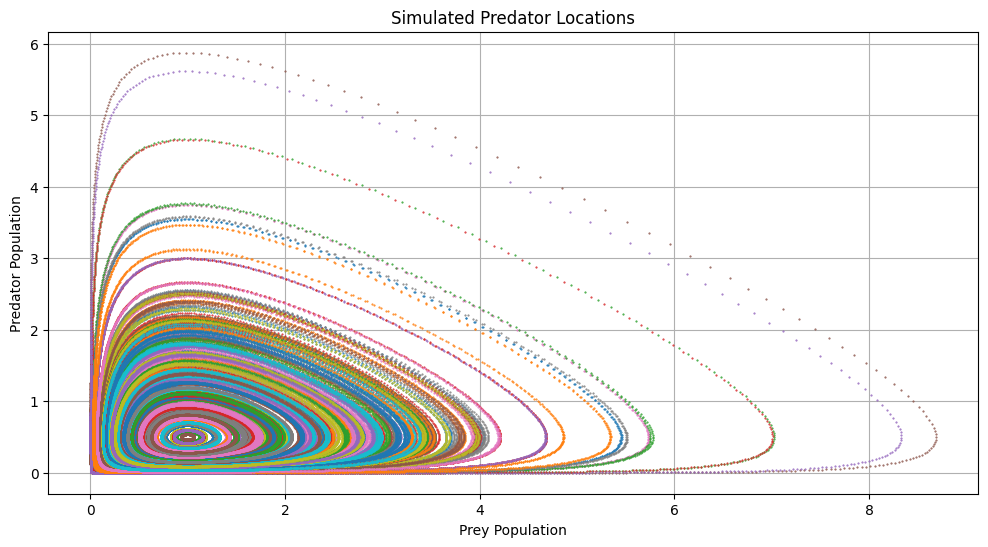

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Load the .npy file containing the simulation data
data = np.load('../Dataset/val.npy')

# Extract prey and predator population data
prey_data = data[:, 0, :]
predator_data = data[:, 1, :]

# Plot the predator locations for each trajectory
plt.figure(figsize=(12, 6))
plt.title('Simulated Predator Locations')

# Plot each trajectory separately
for traj_index in range(len(prey_data)):
    plt.plot(prey_data[traj_index], predator_data[traj_index], '.', markersize=1)

plt.xlabel('Prey Population')
plt.ylabel('Predator Population')
plt.grid(True)
plt.show()

In [25]:
def generate_heatmap(grid_size=100, num_traj=200, len_traj=25, save_loc='../Dataset/val.npy'):
    dataset = np.zeros((num_traj, grid_size, grid_size))

    for k in tqdm(range(num_traj)):
        # Initialize a grid with random predator numbers
        grid = np.random.random((grid_size, grid_size))

        # Run Lotka-Volterra model to simulate predator numbers changing over time
        t_span = [0, len_traj]
        t_grid = np.linspace(t_span[0], t_span[1], len_traj)
        dt = t_grid[1] - t_grid[0]  # Time step

        for t_idx, t in enumerate(t_grid):
            predator_population = np.zeros((grid_size, grid_size))

            # Iterate over grid cells
            for i in range(grid_size):
                for j in range(grid_size):
                    prey = grid[i, j]
                    prey_neighbors = grid[(i+1)%grid_size, (j+1)%grid_size]  # Using toroidal boundary conditions
                    predator_population[i, j] = prey * (ALPHA - BETA * prey_neighbors)

            # Update the grid with the new predator population
            grid += predator_population * dt
            grid = np.clip(grid, 0, 1)  # Ensure predator numbers stay within [0, 1]

        # Assign the predator population to the grid
        dataset[k] = grid

    np.save(save_loc, dataset)

# Example usage
generate_heatmap()

100%|██████████| 200/200 [00:26<00:00,  7.58it/s]


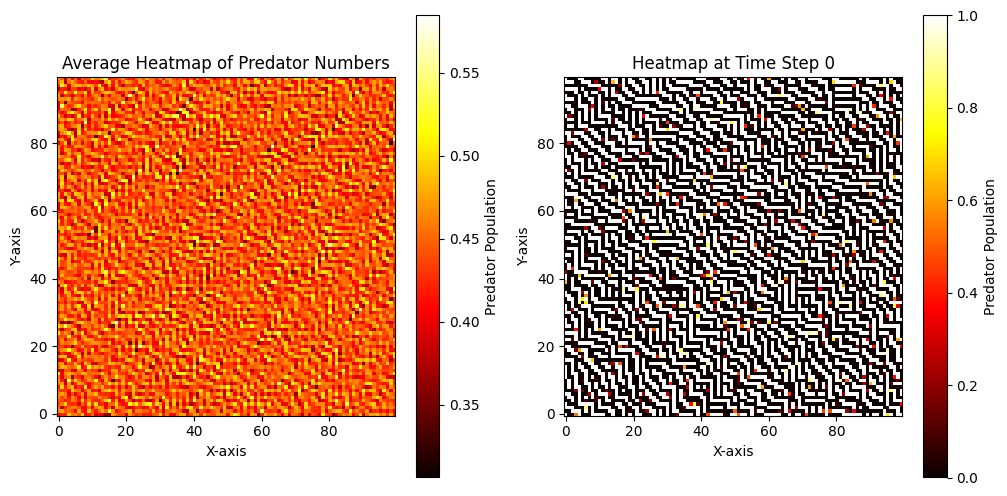

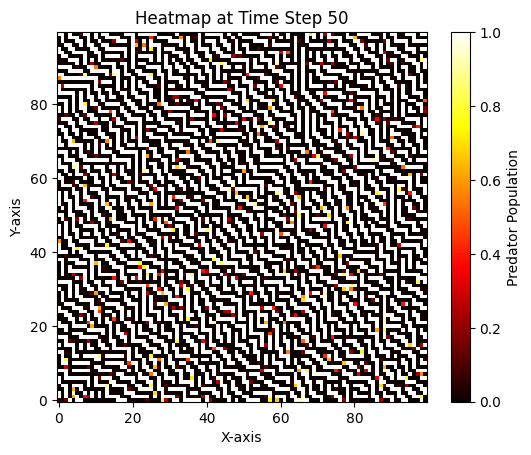

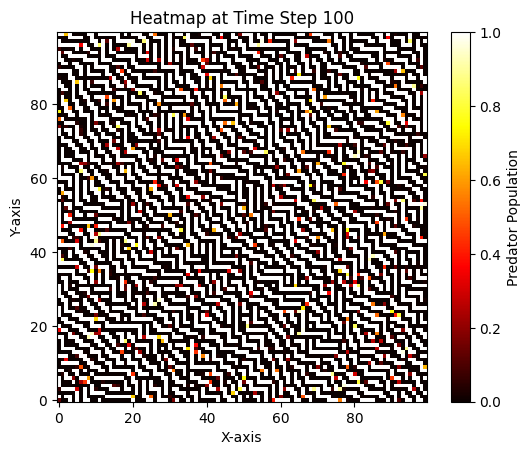

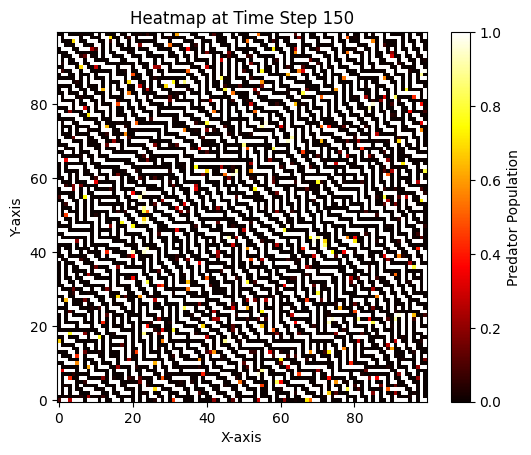

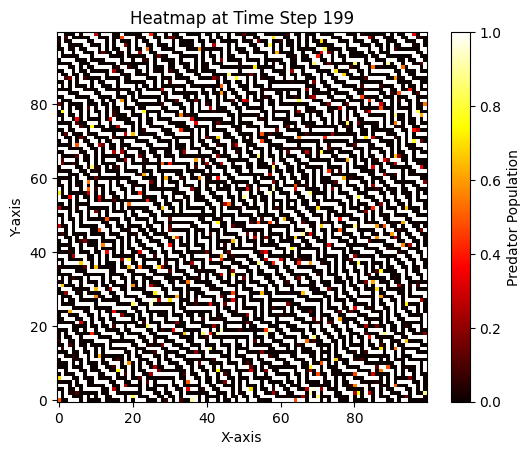

In [27]:
import numpy as np
import matplotlib.pyplot as plt

# Load the generated heatmap data
dataset = np.load('../Dataset/val.npy')

# Calculate average heatmap
average_heatmap = np.mean(dataset, axis=0)

# Plot the average heatmap
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(average_heatmap, cmap='hot', interpolation='nearest', origin='lower')
plt.colorbar(label='Predator Population')
plt.title('Average Heatmap of Predator Numbers')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')

# Select representative timesteps
representative_time_steps = [0, len(dataset)//4, len(dataset)//2, 3*len(dataset)//4, len(dataset)-1]

# Plot representative timesteps and their heatmaps
plt.subplot(1, 2, 2)
for timestep in representative_time_steps:
    heatmap_data = dataset[timestep]
    plt.imshow(heatmap_data, cmap='hot', interpolation='nearest', origin='lower')
    plt.colorbar(label='Predator Population')
    plt.title(f'Heatmap at Time Step {timestep}')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.show()


In [ ]:
#TODO model training. Fix later

# imports
import torch
import numpy as np
from Dataset.dataloader import DynamicalSystem
from torch.utils.data import DataLoader
from models.kkl import KKL
from models.baselines import RNN, GRU
import argparse

parser = argparse.ArgumentParser(description="Train/Evaluate model")
parser.add_argument('--epoch', default=0, type=int, help="Num. of Epochs, set to 0 to evaluate trained model")
parser.add_argument('--lr', default=1e-4, type=float, help="Learning rate")
parser.add_argument('--timespan', default=5, type=int, help="Number of known timesteps")
parser.add_argument('--dataset', default='vanderpol', type=str,
                    help="Dataset selection {vanderpol, lorenz, lotkavolterra, meanfield}")
parser.add_argument('--model', default='kkl', type=str, help="Model to train")
args = parser.parse_args()

TIMESPAN = args.timespan

models = {"kkl": KKL, "rnn": RNN, "gru": GRU}


def evaluate():
    dataloader = DataLoader(DynamicalSystem("test", args.dataset, horizon=100), batch_size=1, shuffle=False)
    latent_space_dim = dataloader.dataset.dim * 2 + 1
    model = models[args.model](observation_dim=1,
                               latent_space_dim=latent_space_dim,
                               prediction_horizon=100,
                               mlp_hidden_dim=128)
    try:
        model.load_state_dict(torch.load("trained_models/" + args.model + "_" + args.dataset + ".nn"))
    except FileNotFoundError:
        model.load_state_dict(torch.load("../trained_models/" + args.model + "_" + args.dataset + ".nn"))

    # Set viz to True to visualize the prediction
    print("TEST error : ", validate(model, dataloader, viz=False))


def visualise(gt, pred):
    import matplotlib.pyplot as plt
    plt.style.use("seaborn")
    plt.title(args.model + " Prediction")
    plt.plot(gt[0], label="Ground Truth")
    plt.plot(pred[0], '--', label="Prediction")
    plt.legend()
    plt.xlabel("Time")
    plt.ylabel("Observation")
    plt.show()


def validate(model, dataloader, viz=False):
    model.eval()
    loss = []
    with torch.no_grad():
        for i, x in enumerate(dataloader):
            obs = x[:, 0, :].unsqueeze(-1)
            prediction = model(obs[:, :TIMESPAN])
            error = ((obs[:, TIMESPAN:] - prediction[:, TIMESPAN:]) ** 2).mean()
            if viz is True:
                visualise(obs, prediction)
            loss.append(error)
        return np.mean(loss)


def train():
    print(args)

    ## CREATE DATALOADER
    train_dataloader = DataLoader(DynamicalSystem("train", args.dataset, horizon=50), shuffle=True,
                                  batch_size=64)
    val_dataloader = DataLoader(DynamicalSystem("val", args.dataset, horizon=50), shuffle=False, batch_size=64)

    ## DEFINE MODEL
    latent_space_dim = train_dataloader.dataset.dim * 2 + 1
    model = models[args.model](observation_dim=1,
                               latent_space_dim=latent_space_dim,
                               prediction_horizon=50,
                               mlp_hidden_dim=128)

    ## OPTIMIZER
    optim = torch.optim.Adam(model.parameters(), lr=args.lr)

    for epoch in range(args.epoch):
        model.train()
        print("=== EPOCH ", epoch + 1, " ===")
        for i, x in enumerate(train_dataloader):
            obs = x[:, 0, :].unsqueeze(-1)  # Extract the observation
            prediction = model(obs[:, :TIMESPAN])  # Predict
            cost = ((obs - prediction) ** 2).mean()  # Compute error

            ## BACKPROP
            optim.zero_grad()
            cost.backward()
            optim.step()

        cost = validate(model, val_dataloader)

        # Save model weights
        try:
            torch.save(model.state_dict(), "trained_models/" + args.model + "_" + args.dataset + ".nn")
        except FileNotFoundError:
            torch.save(model.state_dict(), "../trained_models/" + args.model + "_" + args.dataset + ".nn")


if __name__ == '__main__':
    if args.epoch == 0:
        evaluate()
    else:
        train()
        evaluate()